In [12]:
#Importing packages
import xarray as xr
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pprint
import numpy as np

In [13]:
!conda list intake

# packages in environment at D:\Programmer\Anaconda\envs\artic_cloud_coverage:
#
# Name                    Version                   Build  Channel
intake                    0.6.2              pyhd8ed1ab_0    conda-forge
intake-esm                2021.1.15          pyhd8ed1ab_0    conda-forge


In [14]:
!conda info --envs

# conda environments:
#
base                     D:\Programmer\Anaconda
artic_cloud_coverage  *  D:\Programmer\Anaconda\envs\artic_cloud_coverage



In [15]:
#Getting the data
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [16]:
#Searching for the total cloud cover
cat = col.search(experiment_id=['piControl'], variable_id= ['clt'], table_id='Amon',
                member_id='r1i1p1f1',
                grid_label='gn')

cat = col.search(experiment_id=['piControl'], variable_id= ['clt'], table_id='Amon',
                member_id='r1i1p1f1',
                grid_label='gn')

#Gets the zstore variable so that I can work with just one dataset
value_of_zstore = 1 #Which zstore to get
zstore_dict = cat.unique(columns = "zstore")
zstore_dict = zstore_dict["zstore"] #Nested dictionary
zstore_list = zstore_dict["values"] #Gets the list of zstore values
zstore = zstore_list[value_of_zstore]

cat = col.search(experiment_id=['piControl'], variable_id= ['clt'], table_id='Amon',
                member_id='r1i1p1f1',
                grid_label='gn',
                zstore = zstore)
dset_dict_clt = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})

cat = col.search(experiment_id=['piControl'], variable_id= ['tas'], table_id='Amon',
                member_id='r1i1p1f1',
                grid_label='gn')

zstore_dict = cat.unique(columns = "zstore")
zstore_dict = zstore_dict["zstore"] #Nested dictionary
zstore_list = zstore_dict["values"] #Gets the list of zstore values
zstore = zstore_list[value_of_zstore]

cat = col.search(experiment_id=['piControl'], variable_id= ['tas'], table_id='Amon',
                member_id='r1i1p1f1',
                grid_label='gn',
                zstore = zstore)
dset_dict_tas = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [17]:
#The dataset total cloud cover
key_clt = list(dset_dict_clt.keys())[0] #Converts the key into a list and gets the key
clt_data = dset_dict_clt[key_clt]

#The dataset for total air temprature? Is that what tas is
key_tas = list(dset_dict_tas.keys())[0] #Converts the key into a list and gets the key
tas_data = dset_dict_tas[key_tas]


TODO: Cosine of latitude, to create weights for a weighted mean
See the website http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

TODO: Use intake to search for both a clt and tas, and then use zstore to get one of the databases to download (gets much faster then)

TODO: Then use that to calculate all the different things

In [22]:
print(clt_data.sizes)
dataset_time_mean = clt_data.mean("time")
#To slice the data
# clt_seltime = clt.sel(time=slice(starttime, endtime)) 
# clt_timemean = clt_seltime.mean('time')
print(dataset_time_mean.sizes)

Frozen({'member_id': 1, 'time': 2400, 'lat': 94, 'lon': 192, 'bnds': 2})
Frozen({'member_id': 1, 'lat': 94, 'lon': 192, 'bnds': 2})


In [23]:
# #Area mean of the total cloud cover: Mariannes code did not totally understand it
# minlat = 60. 
# maxlat = 90.
# area_array_gr = xr.open_dataset('/path/to/file/areacella_fx_...._r1i1p1f1_gr.nc') Which type is this? Open dataset
# picontrol = xr.open_dataset('/path/to/file/tas_Amon_......._.nc')

# area_array = area_array_gr.areacella #How does that work?, .areacella??
# area_array = np.expand_dims(area_array, axis=0)
# area_array = np.repeat(area_array, len(picontrol.time), axis = 0) #What is picontrol? and the syntax xarray.time?
# area_array= xr.DataArray(area_array,coords=[picontrol.time,picontrol.lat,picontrol.lon],dims=['time','lat','lon'])
# tas = picontrol.tas.sel(lat=slice(minlat,maxlat))

# w_avg = np.average(tas,axis=(1,2),weights=area_array.sel(lat=slice(minlat,maxlat)))

In [29]:
# Area mean from this webpage: http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html
weights = np.cos(np.deg2rad(clt_data.lat)) #Creating weights
weights.name = "weights"
clt_weighted = clt_data.weighted(weights)
area_mean = clt_weighted.mean(("lon", "lat"))

#Area and time mean
area_and_time_mean = area_mean.mean("time")
area_and_time_mean

<xarray.Dataset>
Dimensions:    (member_id: 1)
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
Data variables:
    clt        (member_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [30]:
#Plot the data use ccrs and cartopy but try to understand wtf is going on
# dataset_time_mean
# fig = plt.figure(1, figsize=[10,10])

# ax = plt.subplot(1, 1, 1, ax = plt.axes(projection=ccrs.NorthPolarStereo())) # map plot of Arctic
# ax.coastlines()

Text(0.5, 1.0, 'January 1926')

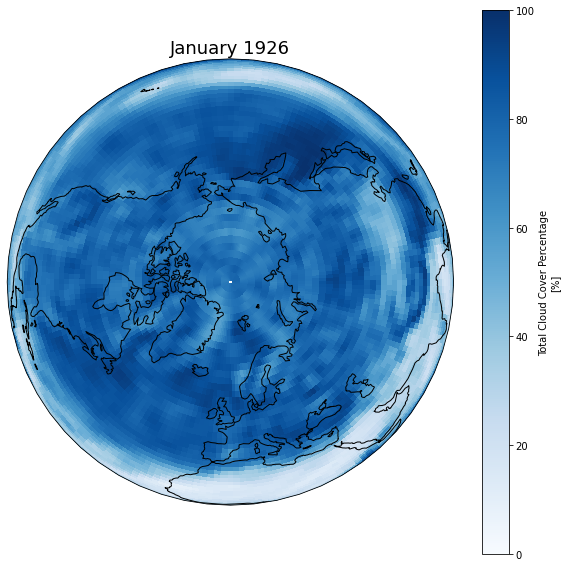

In [33]:
#Plotting of the dataset
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# Fix extent
minval = 0
maxval = 100

# pass extent with vmin and vmax parameters
clt_data['clt'].isel(time=0).plot(ax=ax, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), cmap='Blues')

# One way to customize your title
plt.title(clt_data.time.values[0].strftime("%B %Y"), fontsize=18)

Spørsmål til de andre:
- Mariannes kode: Vizualisering og overflate gjenomsnitt
- Noen jeg kan spørre om visualisering og xarray
- Lage funksjoner fra koden min
- Spørre om overflate gjenomsnitt har regnet det ut riktig